In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Project imports
from src.data_loader import load_and_filter_data
from src.preprocessing import split_features_labels
from src.feature_selection import select_top_features
from src.bayes_optimization import run_all_bayesian_optimizations
from src.optuna_optimization import optimize_with_optuna
from src.xai_interpretation import (
    explain_with_shap,
    explain_with_lime,
    plot_permutation_importance,
    plot_model_feature_importance,
    plot_elasticnet_weights
)

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

model_map = {
    "RandomForest": RandomForestClassifier,
    "CatBoost": CatBoostClassifier,
    "LGBM": LGBMClassifier,
    "XGB": XGBClassifier,
}

# ========================================
# 1. Load + preprocess data
# ========================================
data = load_and_filter_data()
X, y = split_features_labels(data)

# ========================================
# 2. Feature selection
# ========================================
X = X.copy()
selected_features = select_top_features(X, y, top_k=20)
X_selected = X[selected_features]

# ========================================
# 3. Run both optimization methods
# ========================================
print("🔍 Running Bayesian Optimization...")
bayes_results = run_all_bayesian_optimizations(X_selected, y)
print("✅ Done.\n")

print("🔍 Running Optuna Optimization...")
optuna_results = optimize_with_optuna(X_selected, y, n_trials=30)
print("✅ Done.\n")

combined = pd.concat([bayes_results, optuna_results], ignore_index=True)

# ========================================
# 4. Find best model across all results
# ========================================
best_model_info = combined.loc[combined['Best CV Score (ROC AUC)'].idxmax()]
best_model_name = best_model_info['Model']
best_params = best_model_info['Best Parameters']

# Cast types
if best_model_name == "RandomForest":
    best_params["n_estimators"] = int(best_params["n_estimators"])
    if isinstance(best_params.get("max_features", 1), float) and best_params["max_features"] > 1:
        best_params["max_features"] = float(best_params["max_features"])
elif best_model_name == "CatBoost":
    best_params["iterations"] = int(best_params["iterations"])
    best_params["depth"] = int(best_params["depth"])
elif best_model_name == "LGBM":
    best_params["n_estimators"] = int(best_params["n_estimators"])
elif best_model_name == "XGB":
    best_params["n_estimators"] = int(best_params["n_estimators"])
    best_params["max_depth"] = int(best_params["max_depth"])

print(f"🏆 Best Model: {best_model_name}")
print("🔧 Best Parameters:", best_params)

# ========================================
# 5. Cross-validated training & evaluation
# ========================================
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
auc_scores = []
final_model = model_map[best_model_name](**best_params)

for train_idx, test_idx in kf.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

print(f"\n🎯 Mean ROC AUC (10-fold): {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")



import os

# Create results directory
os.makedirs("results", exist_ok=True)

# Save selected features
with open("results/selected_features.txt", "w") as f:
    f.write("\n".join(selected_features))

# Save optimization results
bayes_results.to_csv("results/bayes_results.csv", index=False)
optuna_results.to_csv("results/optuna_results.csv", index=False)
combined.to_csv("results/final_summary.csv", index=False)

# Save final cross-val AUC
with open("results/final_auc.txt", "w") as f:
    f.write(f"Mean AUC: {np.mean(auc_scores):.4f}\n")
    f.write(f"Std AUC: {np.std(auc_scores):.4f}\n")
    f.write(f"Model: {best_model_name}\n")
    f.write(f"Params: {best_params}\n")


/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Running Bayesian Optimization...
|   iter    |  target   | n_esti... | max_fe... |
-------------------------------------------------
| 1         | 0.7916363 | 106.18101 | 0.9556428 |
| 2         | 0.8119999 | 159.79909 | 0.6387926 |
| 3         | 0.8142727 | 73.402796 | 0.2403950 |
| 4         | 0.7962727 | 58.712541 | 0.8795585 |
| 5         | 0.7927272 | 140.16725 | 0.7372653 |
| 6         | 0.8036363 | 53.087674 | 0.9729188 |
| 7         | 0.8332727 | 174.86639 | 0.2911051 |
| 8         | 0.8248181 | 77.273745 | 0.2650640 |
| 9         | 0.8034545 | 95.636336 | 0.5722807 |
| 10        | 0.8028181 | 114.79175 | 0.3621062 |
| 11        | 0.7814545 | 182.06330 | 0.9650160 |
| 12        | 0.8219999 | 172.88162 | 0.1216336 |
| 13        | 0.7916363 | 176.62830 | 1.0       |
| 14        | 0.8158181 | 82.794918 | 0.4234503 |
| 15        | 0.8332727 | 174.87816 | 0.2782414 |
| 16        | 0.7762727 | 75.799788 | 0.8199511 |
| 17        | 0.8230909 | 174.08304 | 0.1       |
| 18        | 0

[I 2025-07-29 11:47:27,469] A new study created in memory with name: no-name-a91a173d-144d-44ce-b4bc-5ecafaff406c


| 40        | 0.8110909 | 179.52723 | 0.1610677 | 4.5302988 |
✅ Done.

🔍 Running Optuna Optimization...
🔍 Optimizing RandomForest with Optuna...


[I 2025-07-29 11:47:31,986] Trial 0 finished with value: 0.844 and parameters: {'n_estimators': 94, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.844.
[I 2025-07-29 11:47:32,307] Trial 1 finished with value: 0.8341818181818181 and parameters: {'n_estimators': 55, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.844.
[I 2025-07-29 11:47:32,992] Trial 2 finished with value: 0.8343636363636364 and parameters: {'n_estimators': 138, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.844.
[I 2025-07-29 11:47:33,770] Trial 3 finished with value: 0.8298181818181819 and parameters: {'n_estimators': 145, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.844.
[I 2025-07-29 11:47:34,564] Trial 4 finished with value: 0.8123636363636363 and parameters: {'n_estimators': 164, 'max_depth': 7, 'min_samples_split': 10, 'min

🔍 Optimizing XGBoost with Optuna...


[I 2025-07-29 11:47:50,870] Trial 0 finished with value: 0.757090909090909 and parameters: {'n_estimators': 81, 'max_depth': 8, 'learning_rate': 0.013951793420805698}. Best is trial 0 with value: 0.757090909090909.
[I 2025-07-29 11:47:51,040] Trial 1 finished with value: 0.7558181818181817 and parameters: {'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.026324521905526727}. Best is trial 0 with value: 0.757090909090909.
[I 2025-07-29 11:47:51,283] Trial 2 finished with value: 0.7685454545454545 and parameters: {'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.042050638596824806}. Best is trial 2 with value: 0.7685454545454545.
[I 2025-07-29 11:47:51,502] Trial 3 finished with value: 0.7481818181818183 and parameters: {'n_estimators': 111, 'max_depth': 8, 'learning_rate': 0.013703352079548184}. Best is trial 2 with value: 0.7685454545454545.
[I 2025-07-29 11:47:51,694] Trial 4 finished with value: 0.7634545454545455 and parameters: {'n_estimators': 92, 'max_depth': 6, 'lea

🔍 Optimizing LGBM with Optuna...


[I 2025-07-29 11:47:56,589] Trial 0 finished with value: 0.8014545454545455 and parameters: {'n_estimators': 185, 'num_leaves': 95, 'learning_rate': 0.28072996817571594}. Best is trial 0 with value: 0.8014545454545455.
[I 2025-07-29 11:47:56,680] Trial 1 finished with value: 0.7565454545454544 and parameters: {'n_estimators': 139, 'num_leaves': 87, 'learning_rate': 0.012473634756089128}. Best is trial 0 with value: 0.8014545454545455.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 11:47:56,808] Trial 2 finished with value: 0.7789090909090909 and parameters: {'n_estimators': 171, 'num_leaves': 69, 'learning_rate': 0.028146044918485744}. Best is trial 0 with value: 0.8014545454545455.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 11:47:56,896] Trial 3 finished with value: 0.8047272727272727 and parameters: {'n_estimators': 156, 'num_leaves': 37, 'learning_rate': 0.13818716307771733}. Best is trial 3 with value: 0.8047272727272727.
[I 2025-07-29 11:47:56,978] Trial 4 finished with value: 0.7658181818181818 and parameters: {'n_estimators': 81, 'num_leaves': 109, 'learning_rate': 0.06178155285620216}. Best is trial 3 with value: 0.8047272727272727.
[I 2025-07-29 11:47:57,076] Trial 5 finished with value: 0.7790909090909091 and parameters: {'n_estimators': 182, 'num_leaves': 69, 'learning_rate': 0.02726060627762272}. Best is trial 3 with value: 0.8047272727272727.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 11:47:57,153] Trial 6 finished with value: 0.742 and parameters: {'n_estimators': 97, 'num_leaves': 52, 'learning_rate': 0.01098289391415846}. Best is trial 3 with value: 0.8047272727272727.
[I 2025-07-29 11:47:57,227] Trial 7 finished with value: 0.7769090909090909 and parameters: {'n_estimators': 98, 'num_leaves': 37, 'learning_rate': 0.05652736948291013}. Best is trial 3 with value: 0.8047272727272727.
[I 2025-07-29 11:47:57,295] Trial 8 finished with value: 0.751090909090909 and parameters: {'n_estimators': 57, 'num_leaves': 147, 'learning_rate': 0.040068863366847694}. Best is trial 3 with value: 0.8047272727272727.


[LightGBM] [Info] Number of positive: 42, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506024 -> initscore=0.024098
[LightGBM] [Info] Start training from score 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-07-29 11:47:57,396] Trial 9 finished with value: 0.8032727272727274 and parameters: {'n_estimators': 100, 'num_leaves': 83, 'learning_rate': 0.19020036980323815}. Best is trial 3 with value: 0.8047272727272727.
[I 2025-07-29 11:47:57,505] Trial 10 finished with value: 0.7956363636363637 and parameters: {'n_estimators': 146, 'num_leaves': 20, 'learning_rate': 0.1164260615482837}. Best is trial 3 with value: 0.8047272727272727.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 11:47:57,615] Trial 11 finished with value: 0.8070909090909091 and parameters: {'n_estimators': 113, 'num_leaves': 112, 'learning_rate': 0.20780509280833281}. Best is trial 11 with value: 0.8070909090909091.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 11:47:57,796] Trial 12 finished with value: 0.7994545454545455 and parameters: {'n_estimators': 153, 'num_leaves': 123, 'learning_rate': 0.13570494119525045}. Best is trial 11 with value: 0.8070909090909091.
[I 2025-07-29 11:47:57,892] Trial 13 finished with value: 0.7956363636363637 and parameters: {'n_estimators': 121, 'num_leaves': 127, 'learning_rate': 0.10470397424711045}. Best is trial 11 with value: 0.8070909090909091.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-07-29 11:47:58,054] Trial 14 finished with value: 0.794 and parameters: {'n_estimators': 200, 'num_leaves': 20, 'learning_rate': 0.25997345639755737}. Best is trial 11 with value: 0.8070909090909091.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 11:47:58,142] Trial 15 finished with value: 0.7994545454545455 and parameters: {'n_estimators': 128, 'num_leaves': 50, 'learning_rate': 0.08657578952241306}. Best is trial 11 with value: 0.8070909090909091.
[I 2025-07-29 11:47:58,295] Trial 16 finished with value: 0.7903636363636364 and parameters: {'n_estimators': 164, 'num_leaves': 108, 'learning_rate': 0.17906518012841274}. Best is trial 11 with value: 0.8070909090909091.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 11:47:58,398] Trial 17 finished with value: 0.7970909090909091 and parameters: {'n_estimators': 120, 'num_leaves': 123, 'learning_rate': 0.17521879921367553}. Best is trial 11 with value: 0.8070909090909091.
[I 2025-07-29 11:47:58,488] Trial 18 finished with value: 0.788 and parameters: {'n_estimators': 133, 'num_leaves': 150, 'learning_rate': 0.08161116957829379}. Best is trial 11 with value: 0.8070909090909091.


[LightGBM] [Info] Number of positive: 42, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506024 -> initscore=0.024098
[LightGBM] [Info] Start training from score 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-07-29 11:47:58,587] Trial 19 finished with value: 0.8034545454545455 and parameters: {'n_estimators': 69, 'num_leaves': 66, 'learning_rate': 0.23764266703982237}. Best is trial 11 with value: 0.8070909090909091.
[I 2025-07-29 11:47:58,696] Trial 20 finished with value: 0.8083636363636364 and parameters: {'n_estimators': 112, 'num_leaves': 37, 'learning_rate': 0.13115619021310015}. Best is trial 20 with value: 0.8083636363636364.


[LightGBM] [Info] Number of positive: 42, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506024 -> initscore=0.024098
[LightGBM] [Info] Start training from score 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-07-29 11:47:58,785] Trial 21 finished with value: 0.8014545454545455 and parameters: {'n_estimators': 111, 'num_leaves': 33, 'learning_rate': 0.14009807573163846}. Best is trial 20 with value: 0.8083636363636364.
[I 2025-07-29 11:47:58,872] Trial 22 finished with value: 0.7845454545454544 and parameters: {'n_estimators': 84, 'num_leaves': 37, 'learning_rate': 0.07542003861679229}. Best is trial 20 with value: 0.8083636363636364.
[I 2025-07-29 11:47:58,959] Trial 23 finished with value: 0.7990909090909091 and parameters: {'n_estimators': 110, 'num_leaves': 53, 'learning_rate': 0.19735000648939408}. Best is trial 20 with value: 0.8083636363636364.


[LightGBM] [Info] Number of positive: 42, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-07-29 11:47:59,064] Trial 24 finished with value: 0.7943636363636364 and parameters: {'n_estimators': 156, 'num_leaves': 105, 'learning_rate': 0.13909570158714984}. Best is trial 20 with value: 0.8083636363636364.
[I 2025-07-29 11:47:59,162] Trial 25 finished with value: 0.7994545454545455 and parameters: {'n_estimators': 139, 'num_leaves': 137, 'learning_rate': 0.2974846150803114}. Best is trial 20 with value: 0.8083636363636364.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 11:47:59,248] Trial 26 finished with value: 0.7827272727272727 and parameters: {'n_estimators': 115, 'num_leaves': 44, 'learning_rate': 0.10165125077397985}. Best is trial 20 with value: 0.8083636363636364.
[I 2025-07-29 11:47:59,327] Trial 27 finished with value: 0.7641818181818182 and parameters: {'n_estimators': 84, 'num_leaves': 78, 'learning_rate': 0.040415610526385724}. Best is trial 20 with value: 0.8083636363636364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 11:47:59,408] Trial 28 finished with value: 0.7943636363636364 and parameters: {'n_estimators': 103, 'num_leaves': 59, 'learning_rate': 0.14906725733075663}. Best is trial 20 with value: 0.8083636363636364.
[I 2025-07-29 11:47:59,536] Trial 29 finished with value: 0.7896363636363636 and parameters: {'n_estimators': 177, 'num_leaves': 92, 'learning_rate': 0.2389829198529572}. Best is trial 20 with value: 0.8083636363636364.
[I 2025-07-29 11:47:59,546] A new study created in memory with name: no-name-19c71818-5bed-4d1e-b3d9-a222e651ec26


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No fu

[I 2025-07-29 11:48:15,282] Trial 0 finished with value: 0.8220000000000001 and parameters: {'iterations': 197, 'depth': 10, 'learning_rate': 0.016871193374308188}. Best is trial 0 with value: 0.8220000000000001.


0:	learn: 0.6746989	total: 22.7ms	remaining: 3.41s
0:	learn: 0.6768577	total: 31.6ms	remaining: 4.73s
1:	learn: 0.6560580	total: 36.8ms	remaining: 2.74s
2:	learn: 0.6403678	total: 61.9ms	remaining: 3.05s
1:	learn: 0.6560454	total: 61.5ms	remaining: 4.58s
2:	learn: 0.6364931	total: 71ms	remaining: 3.5s
3:	learn: 0.6258215	total: 92ms	remaining: 3.38s
3:	learn: 0.6222714	total: 103ms	remaining: 3.77s
4:	learn: 0.6081878	total: 120ms	remaining: 3.5s
4:	learn: 0.6119873	total: 134ms	remaining: 3.92s
5:	learn: 0.5931179	total: 148ms	remaining: 3.57s
5:	learn: 0.5924351	total: 150ms	remaining: 3.63s
6:	learn: 0.5782748	total: 188ms	remaining: 3.86s
6:	learn: 0.5771257	total: 190ms	remaining: 3.91s
7:	learn: 0.5642426	total: 232ms	remaining: 4.14s
7:	learn: 0.5609676	total: 230ms	remaining: 4.1s
8:	learn: 0.5481130	total: 252ms	remaining: 3.98s
8:	learn: 0.5479573	total: 286ms	remaining: 4.51s
9:	learn: 0.5355228	total: 291ms	remaining: 4.11s
9:	learn: 0.5345193	total: 334ms	remaining: 4.72s


[I 2025-07-29 11:48:27,403] Trial 1 finished with value: 0.8032727272727274 and parameters: {'iterations': 151, 'depth': 10, 'learning_rate': 0.028507373856996192}. Best is trial 0 with value: 0.8220000000000001.


150:	learn: 0.0774515	total: 1.93s	remaining: 0us
0:	learn: 0.6450108	total: 4.17ms	remaining: 450ms
1:	learn: 0.5819330	total: 7.99ms	remaining: 427ms
2:	learn: 0.5333561	total: 11.6ms	remaining: 409ms
3:	learn: 0.4887414	total: 16.7ms	remaining: 438ms
0:	learn: 0.6158938	total: 10.9ms	remaining: 1.18s
4:	learn: 0.4441317	total: 25.4ms	remaining: 527ms
1:	learn: 0.5462510	total: 16.3ms	remaining: 874ms
2:	learn: 0.4784227	total: 22.9ms	remaining: 810ms
5:	learn: 0.4013230	total: 31.4ms	remaining: 538ms
6:	learn: 0.3731396	total: 38.2ms	remaining: 556ms
3:	learn: 0.4348578	total: 30.3ms	remaining: 796ms
4:	learn: 0.4063125	total: 37.6ms	remaining: 782ms
7:	learn: 0.3363879	total: 44.4ms	remaining: 561ms
5:	learn: 0.3710237	total: 43.3ms	remaining: 743ms
8:	learn: 0.3144321	total: 51.2ms	remaining: 569ms
6:	learn: 0.3289475	total: 48.1ms	remaining: 700ms
9:	learn: 0.2920365	total: 59.3ms	remaining: 587ms
7:	learn: 0.2972399	total: 54.8ms	remaining: 692ms
10:	learn: 0.2666471	total: 71.4

[I 2025-07-29 11:48:29,396] Trial 2 finished with value: 0.7452727272727273 and parameters: {'iterations': 109, 'depth': 6, 'learning_rate': 0.12026585313428277}. Best is trial 0 with value: 0.8220000000000001.


25:	learn: 0.1211122	total: 65.4ms	remaining: 209ms
26:	learn: 0.1166109	total: 67ms	remaining: 204ms
27:	learn: 0.1112669	total: 68.8ms	remaining: 199ms
28:	learn: 0.1064110	total: 70.7ms	remaining: 195ms
29:	learn: 0.1018058	total: 72.3ms	remaining: 190ms
30:	learn: 0.0947422	total: 74.3ms	remaining: 187ms
31:	learn: 0.0903231	total: 75.7ms	remaining: 182ms
32:	learn: 0.0867359	total: 77.5ms	remaining: 178ms
33:	learn: 0.0827752	total: 78.9ms	remaining: 174ms
34:	learn: 0.0795312	total: 80.5ms	remaining: 170ms
35:	learn: 0.0766954	total: 82.5ms	remaining: 167ms
36:	learn: 0.0735779	total: 84ms	remaining: 163ms
37:	learn: 0.0701799	total: 85.8ms	remaining: 160ms
38:	learn: 0.0676208	total: 87.2ms	remaining: 157ms
39:	learn: 0.0651844	total: 92.4ms	remaining: 159ms
40:	learn: 0.0625807	total: 93.9ms	remaining: 156ms
41:	learn: 0.0601286	total: 98.5ms	remaining: 157ms
42:	learn: 0.0574375	total: 101ms	remaining: 155ms
43:	learn: 0.0549110	total: 102ms	remaining: 151ms
44:	learn: 0.05289

[I 2025-07-29 11:48:30,359] Trial 3 finished with value: 0.7998181818181819 and parameters: {'iterations': 59, 'depth': 5, 'learning_rate': 0.03244240097634544}. Best is trial 0 with value: 0.8220000000000001.


22:	learn: 0.3936035	total: 62.5ms	remaining: 97.8ms
23:	learn: 0.3853944	total: 66.7ms	remaining: 97.3ms
24:	learn: 0.3758589	total: 70ms	remaining: 95.2ms
25:	learn: 0.3696540	total: 71.7ms	remaining: 91.1ms
26:	learn: 0.3631619	total: 74ms	remaining: 87.7ms
27:	learn: 0.3552021	total: 75.5ms	remaining: 83.5ms
28:	learn: 0.3504447	total: 77.4ms	remaining: 80.1ms
29:	learn: 0.3417931	total: 79.3ms	remaining: 76.7ms
30:	learn: 0.3341967	total: 81.9ms	remaining: 74ms
31:	learn: 0.3303216	total: 84.2ms	remaining: 71.1ms
32:	learn: 0.3226645	total: 86.1ms	remaining: 67.8ms
33:	learn: 0.3152143	total: 89.5ms	remaining: 65.8ms
34:	learn: 0.3100384	total: 91.4ms	remaining: 62.7ms
35:	learn: 0.3056443	total: 95ms	remaining: 60.7ms
36:	learn: 0.3020443	total: 96.8ms	remaining: 57.6ms
37:	learn: 0.2973346	total: 101ms	remaining: 55.6ms
38:	learn: 0.2924621	total: 103ms	remaining: 53ms
39:	learn: 0.2872735	total: 106ms	remaining: 50.5ms
40:	learn: 0.2826599	total: 109ms	remaining: 47.8ms
41:	lea

[I 2025-07-29 11:48:32,535] Trial 4 finished with value: 0.8149090909090908 and parameters: {'iterations': 165, 'depth': 5, 'learning_rate': 0.015700253366112766}. Best is trial 0 with value: 0.8220000000000001.


161:	learn: 0.1671821	total: 562ms	remaining: 10.4ms
162:	learn: 0.1654580	total: 563ms	remaining: 6.91ms
163:	learn: 0.1644462	total: 565ms	remaining: 3.44ms
164:	learn: 0.1635864	total: 566ms	remaining: 0us
0:	learn: 0.5442236	total: 23.5ms	remaining: 2.19s
0:	learn: 0.5606158	total: 37.6ms	remaining: 3.5s
1:	learn: 0.4262435	total: 46.8ms	remaining: 2.15s
1:	learn: 0.4349165	total: 62ms	remaining: 2.85s
2:	learn: 0.3527632	total: 77.6ms	remaining: 2.35s
2:	learn: 0.3523613	total: 92.4ms	remaining: 2.8s
3:	learn: 0.2943206	total: 101ms	remaining: 2.27s
4:	learn: 0.2561664	total: 126ms	remaining: 2.23s
3:	learn: 0.2970722	total: 120ms	remaining: 2.7s
5:	learn: 0.2216078	total: 151ms	remaining: 2.22s
6:	learn: 0.1891810	total: 162ms	remaining: 2.02s
4:	learn: 0.2500178	total: 134ms	remaining: 2.38s
7:	learn: 0.1624897	total: 189ms	remaining: 2.03s
5:	learn: 0.2145949	total: 162ms	remaining: 2.37s
6:	learn: 0.1871283	total: 184ms	remaining: 2.29s
8:	learn: 0.1435697	total: 217ms	remaini

[I 2025-07-29 11:48:38,545] Trial 5 finished with value: 0.7661818181818182 and parameters: {'iterations': 94, 'depth': 9, 'learning_rate': 0.2567839468715971}. Best is trial 0 with value: 0.8220000000000001.


91:	learn: 0.0111131	total: 998ms	remaining: 21.7ms
92:	learn: 0.0109904	total: 1s	remaining: 10.8ms
93:	learn: 0.0108753	total: 1.01s	remaining: 0us
0:	learn: 0.6548194	total: 7.29ms	remaining: 1.28s
0:	learn: 0.6364595	total: 7.25ms	remaining: 1.27s
1:	learn: 0.5818950	total: 15.1ms	remaining: 1.32s
1:	learn: 0.5993408	total: 21.2ms	remaining: 1.86s
2:	learn: 0.5387593	total: 21.4ms	remaining: 1.24s
2:	learn: 0.5570079	total: 34.4ms	remaining: 2s
3:	learn: 0.4976921	total: 30.1ms	remaining: 1.3s
4:	learn: 0.4579696	total: 34.3ms	remaining: 1.18s
3:	learn: 0.5165587	total: 48.1ms	remaining: 2.08s
5:	learn: 0.4246047	total: 42.4ms	remaining: 1.21s
4:	learn: 0.4779595	total: 61.2ms	remaining: 2.1s
6:	learn: 0.4055106	total: 52.8ms	remaining: 1.28s
7:	learn: 0.3798764	total: 59.7ms	remaining: 1.26s
5:	learn: 0.4526110	total: 73ms	remaining: 2.08s
8:	learn: 0.3539570	total: 68.3ms	remaining: 1.27s
6:	learn: 0.4243093	total: 85ms	remaining: 2.06s
9:	learn: 0.3353493	total: 76.3ms	remaining

[I 2025-07-29 11:48:42,462] Trial 6 finished with value: 0.7721818181818182 and parameters: {'iterations': 177, 'depth': 7, 'learning_rate': 0.08291676088023835}. Best is trial 0 with value: 0.8220000000000001.


171:	learn: 0.0109740	total: 898ms	remaining: 26.1ms
172:	learn: 0.0108931	total: 900ms	remaining: 20.8ms
173:	learn: 0.0108232	total: 903ms	remaining: 15.6ms
174:	learn: 0.0107347	total: 905ms	remaining: 10.3ms
175:	learn: 0.0106576	total: 907ms	remaining: 5.15ms
176:	learn: 0.0105851	total: 910ms	remaining: 0us
0:	learn: 0.6845834	total: 6.46ms	remaining: 859ms
0:	learn: 0.6817112	total: 9.88ms	remaining: 1.31s
1:	learn: 0.6722477	total: 13.6ms	remaining: 896ms
1:	learn: 0.6689861	total: 15ms	remaining: 992ms
2:	learn: 0.6610873	total: 20.5ms	remaining: 897ms
3:	learn: 0.6509451	total: 26.3ms	remaining: 854ms
4:	learn: 0.6409821	total: 32ms	remaining: 824ms
2:	learn: 0.6589247	total: 30.2ms	remaining: 1.32s
5:	learn: 0.6312437	total: 37.6ms	remaining: 801ms
3:	learn: 0.6491616	total: 39.9ms	remaining: 1.3s
6:	learn: 0.6211571	total: 44.7ms	remaining: 810ms
4:	learn: 0.6393611	total: 48.3ms	remaining: 1.25s
7:	learn: 0.6107038	total: 52.3ms	remaining: 823ms
5:	learn: 0.6294681	total: 

[I 2025-07-29 11:48:47,001] Trial 7 finished with value: 0.8114545454545455 and parameters: {'iterations': 134, 'depth': 8, 'learning_rate': 0.01744280608112827}. Best is trial 0 with value: 0.8220000000000001.


0:	learn: 0.5517328	total: 3.07ms	remaining: 513ms
0:	learn: 0.6055874	total: 2.72ms	remaining: 454ms
1:	learn: 0.4882651	total: 4.21ms	remaining: 349ms
1:	learn: 0.4435806	total: 8.95ms	remaining: 743ms
2:	learn: 0.3709895	total: 10.4ms	remaining: 573ms
2:	learn: 0.4101459	total: 8.82ms	remaining: 485ms
3:	learn: 0.3529447	total: 10.9ms	remaining: 445ms
4:	learn: 0.3042732	total: 12.3ms	remaining: 401ms
3:	learn: 0.3236743	total: 20.1ms	remaining: 823ms
5:	learn: 0.2653658	total: 14ms	remaining: 378ms
6:	learn: 0.2272937	total: 15.7ms	remaining: 362ms
4:	learn: 0.2763041	total: 26ms	remaining: 849ms
7:	learn: 0.2072190	total: 17.2ms	remaining: 345ms
5:	learn: 0.2435111	total: 30.6ms	remaining: 827ms
6:	learn: 0.2114755	total: 32ms	remaining: 737ms
7:	learn: 0.1866876	total: 34.6ms	remaining: 692ms
8:	learn: 0.1824217	total: 21.3ms	remaining: 377ms
8:	learn: 0.1675371	total: 37.2ms	remaining: 658ms
9:	learn: 0.1434554	total: 39.1ms	remaining: 617ms
9:	learn: 0.1670635	total: 29.9ms	rem

[I 2025-07-29 11:48:49,321] Trial 8 finished with value: 0.7725454545454545 and parameters: {'iterations': 168, 'depth': 5, 'learning_rate': 0.23966955728342196}. Best is trial 0 with value: 0.8220000000000001.


166:	learn: 0.0023426	total: 443ms	remaining: 2.65ms
167:	learn: 0.0023246	total: 444ms	remaining: 0us
0:	learn: 0.6682782	total: 17.5ms	remaining: 2.79s
1:	learn: 0.6442398	total: 36ms	remaining: 2.84s
0:	learn: 0.6649248	total: 34.1ms	remaining: 5.43s
2:	learn: 0.6181555	total: 61ms	remaining: 3.19s
1:	learn: 0.6399427	total: 65.5ms	remaining: 5.18s
3:	learn: 0.5963476	total: 99.8ms	remaining: 3.89s
2:	learn: 0.6154864	total: 96.8ms	remaining: 5.06s
4:	learn: 0.5774003	total: 132ms	remaining: 4.09s
3:	learn: 0.5945114	total: 128ms	remaining: 5s
5:	learn: 0.5576623	total: 160ms	remaining: 4.1s
4:	learn: 0.5711016	total: 161ms	remaining: 4.99s
6:	learn: 0.5373921	total: 195ms	remaining: 4.26s
5:	learn: 0.5495219	total: 193ms	remaining: 4.96s
7:	learn: 0.5107823	total: 225ms	remaining: 4.27s
6:	learn: 0.5301933	total: 236ms	remaining: 5.15s
8:	learn: 0.4933223	total: 270ms	remaining: 4.54s
7:	learn: 0.5101385	total: 281ms	remaining: 5.34s
9:	learn: 0.4755685	total: 303ms	remaining: 4.54

[I 2025-07-29 11:48:59,009] Trial 9 finished with value: 0.8094545454545455 and parameters: {'iterations': 160, 'depth': 9, 'learning_rate': 0.04423159647199}. Best is trial 0 with value: 0.8220000000000001.


0:	learn: 0.6860357	total: 24ms	remaining: 4.72s
0:	learn: 0.6868755	total: 39.9ms	remaining: 7.86s
1:	learn: 0.6787031	total: 52.4ms	remaining: 5.14s
1:	learn: 0.6786984	total: 48.6ms	remaining: 4.76s
2:	learn: 0.6708242	total: 56.6ms	remaining: 3.68s
3:	learn: 0.6635705	total: 85.3ms	remaining: 4.14s
2:	learn: 0.6723784	total: 94.7ms	remaining: 6.16s
3:	learn: 0.6664041	total: 129ms	remaining: 6.25s
4:	learn: 0.6606148	total: 147ms	remaining: 5.67s
4:	learn: 0.6582631	total: 161ms	remaining: 6.23s
5:	learn: 0.6510599	total: 181ms	remaining: 5.78s
5:	learn: 0.6525833	total: 180ms	remaining: 5.76s
6:	learn: 0.6452165	total: 227ms	remaining: 6.19s
6:	learn: 0.6460903	total: 219ms	remaining: 5.96s
7:	learn: 0.6391635	total: 251ms	remaining: 5.95s
7:	learn: 0.6398211	total: 248ms	remaining: 5.89s
8:	learn: 0.6331532	total: 278ms	remaining: 5.85s
8:	learn: 0.6324243	total: 275ms	remaining: 5.77s
9:	learn: 0.6269151	total: 307ms	remaining: 5.77s
9:	learn: 0.6261363	total: 315ms	remaining: 5

[I 2025-07-29 11:49:12,259] Trial 10 finished with value: 0.818 and parameters: {'iterations': 198, 'depth': 10, 'learning_rate': 0.010909157348871023}. Best is trial 0 with value: 0.8220000000000001.


195:	learn: 0.1666638	total: 2.42s	remaining: 24.7ms
196:	learn: 0.1656912	total: 2.43s	remaining: 12.3ms
197:	learn: 0.1649447	total: 2.44s	remaining: 0us
0:	learn: 0.6865523	total: 19ms	remaining: 3.58s
0:	learn: 0.6873305	total: 33.2ms	remaining: 6.25s
1:	learn: 0.6797382	total: 33.4ms	remaining: 3.12s
2:	learn: 0.6738647	total: 46.8ms	remaining: 2.9s
1:	learn: 0.6797436	total: 51.4ms	remaining: 4.8s
2:	learn: 0.6724202	total: 58.6ms	remaining: 3.63s
3:	learn: 0.6683076	total: 76.6ms	remaining: 3.54s
3:	learn: 0.6656714	total: 102ms	remaining: 4.74s
4:	learn: 0.6629170	total: 119ms	remaining: 4.39s
4:	learn: 0.6607281	total: 131ms	remaining: 4.83s
5:	learn: 0.6554343	total: 135ms	remaining: 4.13s
5:	learn: 0.6540140	total: 175ms	remaining: 5.34s
6:	learn: 0.6493778	total: 170ms	remaining: 4.42s
6:	learn: 0.6485601	total: 213ms	remaining: 5.53s
7:	learn: 0.6435248	total: 221ms	remaining: 5.01s
7:	learn: 0.6429061	total: 242ms	remaining: 5.47s
8:	learn: 0.6366118	total: 272ms	remainin

[I 2025-07-29 11:49:24,450] Trial 11 finished with value: 0.8218181818181817 and parameters: {'iterations': 189, 'depth': 10, 'learning_rate': 0.01011579048804765}. Best is trial 0 with value: 0.8220000000000001.


184:	learn: 0.1899713	total: 2.32s	remaining: 50.2ms
185:	learn: 0.1890202	total: 2.33s	remaining: 37.6ms
186:	learn: 0.1880168	total: 2.34s	remaining: 25.1ms
187:	learn: 0.1870997	total: 2.35s	remaining: 12.5ms
188:	learn: 0.1862302	total: 2.37s	remaining: 0us
0:	learn: 0.6880214	total: 12.8ms	remaining: 2.56s
0:	learn: 0.6863008	total: 10.4ms	remaining: 2.06s
1:	learn: 0.6805880	total: 21.1ms	remaining: 2.09s
1:	learn: 0.6786149	total: 18.3ms	remaining: 1.81s
2:	learn: 0.6738035	total: 31.7ms	remaining: 2.08s
2:	learn: 0.6724714	total: 26.2ms	remaining: 1.72s
3:	learn: 0.6664625	total: 34.4ms	remaining: 1.68s
3:	learn: 0.6675822	total: 42.4ms	remaining: 2.08s
4:	learn: 0.6603822	total: 42.3ms	remaining: 1.65s
4:	learn: 0.6614217	total: 50.1ms	remaining: 1.95s
5:	learn: 0.6553396	total: 57.5ms	remaining: 1.86s
5:	learn: 0.6541887	total: 51ms	remaining: 1.65s
6:	learn: 0.6478822	total: 59.4ms	remaining: 1.64s
6:	learn: 0.6489925	total: 72.1ms	remaining: 1.99s
7:	learn: 0.6417904	total:

[I 2025-07-29 11:49:29,643] Trial 12 finished with value: 0.8150909090909091 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.010411133496480913}. Best is trial 0 with value: 0.8220000000000001.


176:	learn: 0.1871275	total: 719ms	remaining: 93.4ms
177:	learn: 0.1860197	total: 723ms	remaining: 89.3ms
178:	learn: 0.1848672	total: 727ms	remaining: 85.2ms
179:	learn: 0.1839091	total: 730ms	remaining: 81.1ms
180:	learn: 0.1827690	total: 735ms	remaining: 77.2ms
181:	learn: 0.1818434	total: 739ms	remaining: 73.1ms
182:	learn: 0.1809274	total: 742ms	remaining: 69ms
183:	learn: 0.1802412	total: 746ms	remaining: 64.9ms
184:	learn: 0.1793794	total: 749ms	remaining: 60.8ms
185:	learn: 0.1783385	total: 753ms	remaining: 56.7ms
186:	learn: 0.1770268	total: 757ms	remaining: 52.6ms
187:	learn: 0.1760132	total: 760ms	remaining: 48.5ms
188:	learn: 0.1752695	total: 764ms	remaining: 44.4ms
189:	learn: 0.1743687	total: 767ms	remaining: 40.4ms
190:	learn: 0.1734281	total: 771ms	remaining: 36.3ms
191:	learn: 0.1726245	total: 775ms	remaining: 32.3ms
192:	learn: 0.1716205	total: 778ms	remaining: 28.2ms
193:	learn: 0.1709670	total: 782ms	remaining: 24.2ms
194:	learn: 0.1701845	total: 785ms	remaining: 20

[I 2025-07-29 11:49:41,876] Trial 13 finished with value: 0.8163636363636364 and parameters: {'iterations': 183, 'depth': 10, 'learning_rate': 0.02164696350711694}. Best is trial 0 with value: 0.8220000000000001.


179:	learn: 0.0876993	total: 2.08s	remaining: 34.6ms
180:	learn: 0.0871656	total: 2.09s	remaining: 23.1ms
181:	learn: 0.0865984	total: 2.1s	remaining: 11.5ms
182:	learn: 0.0860136	total: 2.11s	remaining: 0us
0:	learn: 0.6835857	total: 12.6ms	remaining: 1.7s
0:	learn: 0.6847325	total: 19.5ms	remaining: 2.63s
1:	learn: 0.6748141	total: 24.2ms	remaining: 1.62s
1:	learn: 0.6758351	total: 31.7ms	remaining: 2.12s
2:	learn: 0.6659542	total: 38.2ms	remaining: 1.7s
2:	learn: 0.6664548	total: 43.8ms	remaining: 1.94s
3:	learn: 0.6580813	total: 48ms	remaining: 1.58s
3:	learn: 0.6582570	total: 57.2ms	remaining: 1.89s
4:	learn: 0.6505664	total: 61.6ms	remaining: 1.61s
4:	learn: 0.6509236	total: 69.4ms	remaining: 1.82s
5:	learn: 0.6418508	total: 74.3ms	remaining: 1.61s
5:	learn: 0.6424447	total: 81.6ms	remaining: 1.77s
6:	learn: 0.6337328	total: 88.2ms	remaining: 1.63s
6:	learn: 0.6341353	total: 92.6ms	remaining: 1.71s
7:	learn: 0.6250554	total: 103ms	remaining: 1.65s
7:	learn: 0.6229005	total: 106ms

[I 2025-07-29 11:49:48,011] Trial 14 finished with value: 0.8278181818181818 and parameters: {'iterations': 136, 'depth': 9, 'learning_rate': 0.014797672790489469}. Best is trial 14 with value: 0.8278181818181818.


116:	learn: 0.2012094	total: 813ms	remaining: 132ms
117:	learn: 0.1997022	total: 826ms	remaining: 126ms
118:	learn: 0.1984183	total: 834ms	remaining: 119ms
119:	learn: 0.1966706	total: 843ms	remaining: 112ms
120:	learn: 0.1949836	total: 852ms	remaining: 106ms
121:	learn: 0.1933191	total: 861ms	remaining: 98.8ms
122:	learn: 0.1917470	total: 867ms	remaining: 91.6ms
123:	learn: 0.1902950	total: 874ms	remaining: 84.5ms
124:	learn: 0.1891183	total: 881ms	remaining: 77.6ms
125:	learn: 0.1874811	total: 888ms	remaining: 70.5ms
126:	learn: 0.1860577	total: 894ms	remaining: 63.4ms
127:	learn: 0.1846904	total: 900ms	remaining: 56.3ms
128:	learn: 0.1834005	total: 906ms	remaining: 49.2ms
129:	learn: 0.1819050	total: 914ms	remaining: 42.2ms
130:	learn: 0.1806362	total: 920ms	remaining: 35.1ms
131:	learn: 0.1790948	total: 927ms	remaining: 28.1ms
132:	learn: 0.1776415	total: 933ms	remaining: 21ms
133:	learn: 0.1763826	total: 940ms	remaining: 14ms
134:	learn: 0.1750509	total: 946ms	remaining: 7.01ms
13

[I 2025-07-29 11:49:51,799] Trial 15 finished with value: 0.7783636363636364 and parameters: {'iterations': 134, 'depth': 8, 'learning_rate': 0.061064352244702}. Best is trial 14 with value: 0.8278181818181818.


131:	learn: 0.0265773	total: 545ms	remaining: 8.26ms
132:	learn: 0.0263000	total: 549ms	remaining: 4.13ms
133:	learn: 0.0259414	total: 554ms	remaining: 0us
0:	learn: 0.6786188	total: 15.8ms	remaining: 1.37s
0:	learn: 0.6766448	total: 14.9ms	remaining: 1.29s
1:	learn: 0.6634251	total: 28.9ms	remaining: 1.24s
1:	learn: 0.6616946	total: 33.4ms	remaining: 1.44s
2:	learn: 0.6475946	total: 41.7ms	remaining: 1.18s
2:	learn: 0.6467706	total: 47.5ms	remaining: 1.34s
3:	learn: 0.6336824	total: 60.5ms	remaining: 1.27s
3:	learn: 0.6339797	total: 64ms	remaining: 1.34s
4:	learn: 0.6187199	total: 73.1ms	remaining: 1.21s
4:	learn: 0.6219450	total: 94.6ms	remaining: 1.57s
5:	learn: 0.6046544	total: 94.4ms	remaining: 1.29s
6:	learn: 0.5917344	total: 116ms	remaining: 1.34s
5:	learn: 0.6083972	total: 121ms	remaining: 1.65s
7:	learn: 0.5780924	total: 136ms	remaining: 1.36s
6:	learn: 0.5950625	total: 152ms	remaining: 1.76s
8:	learn: 0.5649136	total: 158ms	remaining: 1.39s
7:	learn: 0.5772053	total: 177ms	re

[I 2025-07-29 11:49:55,820] Trial 16 finished with value: 0.8209090909090907 and parameters: {'iterations': 88, 'depth': 9, 'learning_rate': 0.02566442701312089}. Best is trial 14 with value: 0.8278181818181818.


83:	learn: 0.1641777	total: 688ms	remaining: 32.7ms
84:	learn: 0.1616134	total: 700ms	remaining: 24.7ms
85:	learn: 0.1598877	total: 707ms	remaining: 16.4ms
86:	learn: 0.1582733	total: 724ms	remaining: 8.32ms
87:	learn: 0.1556037	total: 748ms	remaining: 0us
0:	learn: 0.6855813	total: 7.09ms	remaining: 425ms
1:	learn: 0.6738288	total: 11.7ms	remaining: 346ms
2:	learn: 0.6641903	total: 16.6ms	remaining: 321ms
0:	learn: 0.6819129	total: 6.99ms	remaining: 419ms
3:	learn: 0.6541435	total: 24.8ms	remaining: 354ms
1:	learn: 0.6701041	total: 14.1ms	remaining: 415ms
2:	learn: 0.6598186	total: 19.9ms	remaining: 384ms
4:	learn: 0.6437540	total: 32.8ms	remaining: 367ms
3:	learn: 0.6492671	total: 24.3ms	remaining: 346ms
4:	learn: 0.6378891	total: 27.5ms	remaining: 308ms
5:	learn: 0.6360058	total: 40.6ms	remaining: 372ms
5:	learn: 0.6275799	total: 32.8ms	remaining: 301ms
6:	learn: 0.6273729	total: 46.1ms	remaining: 355ms
6:	learn: 0.6215531	total: 37.7ms	remaining: 291ms
7:	learn: 0.6180648	total: 51

[I 2025-07-29 11:49:57,117] Trial 17 finished with value: 0.8225454545454547 and parameters: {'iterations': 61, 'depth': 7, 'learning_rate': 0.015881734755376124}. Best is trial 14 with value: 0.8278181818181818.


11:	learn: 0.5791233	total: 66.1ms	remaining: 270ms
12:	learn: 0.5712769	total: 72.6ms	remaining: 268ms
13:	learn: 0.5633312	total: 74.9ms	remaining: 251ms
14:	learn: 0.5552969	total: 77.3ms	remaining: 237ms
15:	learn: 0.5484925	total: 80.2ms	remaining: 226ms
16:	learn: 0.5408138	total: 82.3ms	remaining: 213ms
17:	learn: 0.5321572	total: 84.5ms	remaining: 202ms
18:	learn: 0.5252691	total: 87.6ms	remaining: 194ms
19:	learn: 0.5197616	total: 91.3ms	remaining: 187ms
20:	learn: 0.5115997	total: 94.1ms	remaining: 179ms
21:	learn: 0.5057293	total: 97.3ms	remaining: 173ms
22:	learn: 0.5003149	total: 100ms	remaining: 165ms
23:	learn: 0.4932474	total: 102ms	remaining: 158ms
24:	learn: 0.4880889	total: 106ms	remaining: 153ms
25:	learn: 0.4821733	total: 109ms	remaining: 147ms
26:	learn: 0.4759371	total: 112ms	remaining: 141ms
27:	learn: 0.4700722	total: 114ms	remaining: 134ms
28:	learn: 0.4651702	total: 116ms	remaining: 128ms
29:	learn: 0.4599508	total: 118ms	remaining: 122ms
30:	learn: 0.4551251

[I 2025-07-29 11:49:58,465] Trial 18 finished with value: 0.8312727272727273 and parameters: {'iterations': 61, 'depth': 7, 'learning_rate': 0.04345622358468594}. Best is trial 18 with value: 0.8312727272727273.


39:	learn: 0.2021612	total: 156ms	remaining: 82ms
40:	learn: 0.1972781	total: 159ms	remaining: 77.3ms
41:	learn: 0.1917358	total: 161ms	remaining: 72.7ms
42:	learn: 0.1878211	total: 163ms	remaining: 68.2ms
43:	learn: 0.1836538	total: 165ms	remaining: 63.8ms
44:	learn: 0.1791599	total: 168ms	remaining: 59.7ms
45:	learn: 0.1752209	total: 170ms	remaining: 55.6ms
46:	learn: 0.1712012	total: 173ms	remaining: 51.4ms
47:	learn: 0.1671291	total: 175ms	remaining: 47.4ms
48:	learn: 0.1633257	total: 177ms	remaining: 43.4ms
49:	learn: 0.1594060	total: 179ms	remaining: 39.5ms
50:	learn: 0.1559851	total: 182ms	remaining: 35.6ms
51:	learn: 0.1528799	total: 184ms	remaining: 31.8ms
52:	learn: 0.1490219	total: 186ms	remaining: 28.1ms
53:	learn: 0.1466439	total: 188ms	remaining: 24.4ms
54:	learn: 0.1438031	total: 190ms	remaining: 20.8ms
55:	learn: 0.1418664	total: 193ms	remaining: 17.2ms
56:	learn: 0.1391575	total: 197ms	remaining: 13.9ms
57:	learn: 0.1365692	total: 201ms	remaining: 10.4ms
58:	learn: 0.1

[I 2025-07-29 11:49:59,672] Trial 19 finished with value: 0.7996363636363636 and parameters: {'iterations': 114, 'depth': 4, 'learning_rate': 0.13972350783918722}. Best is trial 18 with value: 0.8312727272727273.


99:	learn: 0.0109788	total: 113ms	remaining: 15.8ms
100:	learn: 0.0108619	total: 114ms	remaining: 14.6ms
101:	learn: 0.0107491	total: 115ms	remaining: 13.5ms
102:	learn: 0.0106332	total: 115ms	remaining: 12.3ms
103:	learn: 0.0104565	total: 116ms	remaining: 11.2ms
104:	learn: 0.0102238	total: 117ms	remaining: 10ms
105:	learn: 0.0101320	total: 118ms	remaining: 8.89ms
106:	learn: 0.0099128	total: 119ms	remaining: 7.76ms
107:	learn: 0.0097647	total: 119ms	remaining: 6.63ms
108:	learn: 0.0095965	total: 120ms	remaining: 5.51ms
109:	learn: 0.0094500	total: 121ms	remaining: 4.41ms
110:	learn: 0.0093619	total: 122ms	remaining: 3.3ms
111:	learn: 0.0092771	total: 123ms	remaining: 2.19ms
112:	learn: 0.0091542	total: 124ms	remaining: 1.09ms
113:	learn: 0.0089402	total: 124ms	remaining: 0us
0:	learn: 0.6621102	total: 3.06ms	remaining: 220ms
0:	learn: 0.6738489	total: 4.98ms	remaining: 359ms
1:	learn: 0.6408068	total: 6.59ms	remaining: 234ms
1:	learn: 0.6342840	total: 7.82ms	remaining: 278ms
2:	learn

[I 2025-07-29 11:50:00,842] Trial 20 finished with value: 0.7961818181818182 and parameters: {'iterations': 73, 'depth': 6, 'learning_rate': 0.04641816005240935}. Best is trial 18 with value: 0.8312727272727273.


6:	learn: 0.5054516	total: 20.4ms	remaining: 192ms
7:	learn: 0.4831914	total: 22.6ms	remaining: 184ms
8:	learn: 0.4639119	total: 24.9ms	remaining: 177ms
9:	learn: 0.4463369	total: 26.7ms	remaining: 168ms
10:	learn: 0.4356162	total: 28.5ms	remaining: 161ms
11:	learn: 0.4218530	total: 30.3ms	remaining: 154ms
12:	learn: 0.4037058	total: 32.3ms	remaining: 149ms
13:	learn: 0.3899814	total: 34.4ms	remaining: 145ms
14:	learn: 0.3791310	total: 36.7ms	remaining: 142ms
15:	learn: 0.3645637	total: 38.8ms	remaining: 138ms
16:	learn: 0.3520376	total: 41.5ms	remaining: 137ms
17:	learn: 0.3413258	total: 43.5ms	remaining: 133ms
18:	learn: 0.3347448	total: 45.7ms	remaining: 130ms
19:	learn: 0.3249316	total: 47.5ms	remaining: 126ms
20:	learn: 0.3180367	total: 49.4ms	remaining: 122ms
21:	learn: 0.3074124	total: 51.5ms	remaining: 119ms
22:	learn: 0.2991202	total: 53.7ms	remaining: 117ms
23:	learn: 0.2885838	total: 56ms	remaining: 114ms
24:	learn: 0.2802036	total: 58.1ms	remaining: 112ms
25:	learn: 0.27140

[I 2025-07-29 11:50:02,247] Trial 21 finished with value: 0.8241818181818182 and parameters: {'iterations': 54, 'depth': 7, 'learning_rate': 0.034039678562723434}. Best is trial 18 with value: 0.8312727272727273.


16:	learn: 0.4142798	total: 87ms	remaining: 189ms
17:	learn: 0.4013860	total: 95.8ms	remaining: 192ms
18:	learn: 0.3909602	total: 103ms	remaining: 190ms
19:	learn: 0.3799786	total: 108ms	remaining: 184ms
20:	learn: 0.3707627	total: 111ms	remaining: 174ms
21:	learn: 0.3632192	total: 113ms	remaining: 164ms
22:	learn: 0.3556222	total: 115ms	remaining: 155ms
23:	learn: 0.3466464	total: 117ms	remaining: 147ms
24:	learn: 0.3396922	total: 120ms	remaining: 139ms
25:	learn: 0.3305595	total: 122ms	remaining: 131ms
26:	learn: 0.3226608	total: 124ms	remaining: 124ms
27:	learn: 0.3155494	total: 126ms	remaining: 117ms
28:	learn: 0.3073076	total: 128ms	remaining: 110ms
29:	learn: 0.3012376	total: 130ms	remaining: 104ms
30:	learn: 0.2965321	total: 132ms	remaining: 97.8ms
31:	learn: 0.2912559	total: 134ms	remaining: 92.2ms
32:	learn: 0.2863554	total: 136ms	remaining: 86.7ms
33:	learn: 0.2820068	total: 138ms	remaining: 81.4ms
34:	learn: 0.2754662	total: 141ms	remaining: 76.3ms
35:	learn: 0.2690841	total

[I 2025-07-29 11:50:03,204] Trial 22 finished with value: 0.8130909090909091 and parameters: {'iterations': 52, 'depth': 6, 'learning_rate': 0.03692998360558689}. Best is trial 18 with value: 0.8312727272727273.


33:	learn: 0.2683293	total: 100ms	remaining: 53ms
34:	learn: 0.2623717	total: 102ms	remaining: 49.6ms
35:	learn: 0.2557244	total: 104ms	remaining: 46.2ms
36:	learn: 0.2498193	total: 106ms	remaining: 43ms
37:	learn: 0.2453430	total: 108ms	remaining: 39.8ms
38:	learn: 0.2397067	total: 110ms	remaining: 36.7ms
39:	learn: 0.2347737	total: 112ms	remaining: 33.5ms
40:	learn: 0.2294618	total: 113ms	remaining: 30.3ms
41:	learn: 0.2248980	total: 114ms	remaining: 27.2ms
42:	learn: 0.2200192	total: 116ms	remaining: 24.2ms
43:	learn: 0.2149146	total: 118ms	remaining: 21.5ms
44:	learn: 0.2115755	total: 120ms	remaining: 18.6ms
45:	learn: 0.2080222	total: 121ms	remaining: 15.8ms
46:	learn: 0.2047597	total: 123ms	remaining: 13.1ms
47:	learn: 0.2011116	total: 125ms	remaining: 10.4ms
48:	learn: 0.1969599	total: 126ms	remaining: 7.74ms
49:	learn: 0.1938205	total: 128ms	remaining: 5.13ms
50:	learn: 0.1909744	total: 130ms	remaining: 2.54ms
51:	learn: 0.1877063	total: 131ms	remaining: 0us
0:	learn: 0.6470720

[I 2025-07-29 11:50:04,833] Trial 23 finished with value: 0.8345454545454546 and parameters: {'iterations': 76, 'depth': 7, 'learning_rate': 0.06683392864220744}. Best is trial 23 with value: 0.8345454545454546.


67:	learn: 0.0648895	total: 179ms	remaining: 21ms
68:	learn: 0.0636585	total: 182ms	remaining: 18.4ms
69:	learn: 0.0626263	total: 184ms	remaining: 15.8ms
70:	learn: 0.0613488	total: 186ms	remaining: 13.1ms
71:	learn: 0.0600516	total: 190ms	remaining: 10.6ms
72:	learn: 0.0586502	total: 193ms	remaining: 7.91ms
73:	learn: 0.0574608	total: 195ms	remaining: 5.26ms
74:	learn: 0.0564985	total: 197ms	remaining: 2.63ms
75:	learn: 0.0552256	total: 199ms	remaining: 0us
0:	learn: 0.6409392	total: 5.44ms	remaining: 435ms
1:	learn: 0.5875167	total: 9.26ms	remaining: 366ms
0:	learn: 0.6539577	total: 18.4ms	remaining: 1.47s
2:	learn: 0.5493681	total: 18.3ms	remaining: 475ms
1:	learn: 0.6058746	total: 26.2ms	remaining: 1.03s
3:	learn: 0.5148915	total: 27.8ms	remaining: 536ms
2:	learn: 0.5614873	total: 34.5ms	remaining: 896ms
4:	learn: 0.4816185	total: 35ms	remaining: 532ms
3:	learn: 0.5241257	total: 43.1ms	remaining: 830ms
4:	learn: 0.4900704	total: 51.3ms	remaining: 779ms
5:	learn: 0.4588808	total: 59

[I 2025-07-29 11:50:07,372] Trial 24 finished with value: 0.8052727272727273 and parameters: {'iterations': 81, 'depth': 8, 'learning_rate': 0.08189878445321004}. Best is trial 23 with value: 0.8345454545454546.


63:	learn: 0.0534753	total: 373ms	remaining: 99.2ms
64:	learn: 0.0521134	total: 378ms	remaining: 93ms
65:	learn: 0.0508152	total: 382ms	remaining: 86.8ms
66:	learn: 0.0498588	total: 386ms	remaining: 80.6ms
67:	learn: 0.0486641	total: 391ms	remaining: 74.7ms
68:	learn: 0.0475200	total: 394ms	remaining: 68.6ms
69:	learn: 0.0465834	total: 398ms	remaining: 62.5ms
70:	learn: 0.0456914	total: 402ms	remaining: 56.6ms
71:	learn: 0.0448217	total: 405ms	remaining: 50.6ms
72:	learn: 0.0439314	total: 409ms	remaining: 44.8ms
73:	learn: 0.0429473	total: 412ms	remaining: 39ms
74:	learn: 0.0420344	total: 416ms	remaining: 33.2ms
75:	learn: 0.0411443	total: 419ms	remaining: 27.6ms
76:	learn: 0.0402333	total: 423ms	remaining: 22ms
77:	learn: 0.0395907	total: 427ms	remaining: 16.4ms
78:	learn: 0.0390190	total: 430ms	remaining: 10.9ms
79:	learn: 0.0381771	total: 434ms	remaining: 5.42ms
80:	learn: 0.0371725	total: 438ms	remaining: 0us
0:	learn: 0.6471554	total: 4.76ms	remaining: 343ms
0:	learn: 0.6620832	to

[I 2025-07-29 11:50:08,929] Trial 25 finished with value: 0.8361818181818181 and parameters: {'iterations': 73, 'depth': 7, 'learning_rate': 0.06670815905044561}. Best is trial 25 with value: 0.8361818181818181.


18:	learn: 0.2538094	total: 74.1ms	remaining: 211ms
19:	learn: 0.2448001	total: 80.2ms	remaining: 212ms
20:	learn: 0.2353871	total: 84.3ms	remaining: 209ms
21:	learn: 0.2265687	total: 88.6ms	remaining: 205ms
22:	learn: 0.2164333	total: 93ms	remaining: 202ms
23:	learn: 0.2098494	total: 98.4ms	remaining: 201ms
24:	learn: 0.2023694	total: 102ms	remaining: 196ms
25:	learn: 0.1940707	total: 106ms	remaining: 192ms
26:	learn: 0.1865376	total: 108ms	remaining: 184ms
27:	learn: 0.1820998	total: 110ms	remaining: 177ms
28:	learn: 0.1749438	total: 112ms	remaining: 171ms
29:	learn: 0.1690959	total: 115ms	remaining: 164ms
30:	learn: 0.1644943	total: 117ms	remaining: 158ms
31:	learn: 0.1603122	total: 119ms	remaining: 152ms
32:	learn: 0.1544921	total: 121ms	remaining: 147ms
33:	learn: 0.1503424	total: 123ms	remaining: 141ms
34:	learn: 0.1459126	total: 125ms	remaining: 136ms
35:	learn: 0.1414799	total: 128ms	remaining: 131ms
36:	learn: 0.1369411	total: 130ms	remaining: 127ms
37:	learn: 0.1332706	total:

[I 2025-07-29 11:50:10,430] Trial 26 finished with value: 0.8289090909090909 and parameters: {'iterations': 70, 'depth': 7, 'learning_rate': 0.06821244202303355}. Best is trial 25 with value: 0.8361818181818181.


60:	learn: 0.0748413	total: 214ms	remaining: 31.5ms
61:	learn: 0.0732467	total: 217ms	remaining: 28ms
62:	learn: 0.0716262	total: 219ms	remaining: 24.3ms
63:	learn: 0.0704396	total: 221ms	remaining: 20.7ms
64:	learn: 0.0687729	total: 223ms	remaining: 17.2ms
65:	learn: 0.0661474	total: 226ms	remaining: 13.7ms
66:	learn: 0.0650531	total: 229ms	remaining: 10.3ms
67:	learn: 0.0639934	total: 231ms	remaining: 6.79ms
68:	learn: 0.0622331	total: 233ms	remaining: 3.38ms
69:	learn: 0.0612573	total: 235ms	remaining: 0us
0:	learn: 0.6000657	total: 2.43ms	remaining: 245ms
1:	learn: 0.5188570	total: 4.1ms	remaining: 205ms
0:	learn: 0.6351085	total: 6.52ms	remaining: 658ms
2:	learn: 0.4427105	total: 6.49ms	remaining: 214ms
3:	learn: 0.4054736	total: 7.95ms	remaining: 195ms
1:	learn: 0.5608414	total: 12.1ms	remaining: 605ms
4:	learn: 0.3690587	total: 10.9ms	remaining: 212ms
2:	learn: 0.5061900	total: 17.5ms	remaining: 579ms
5:	learn: 0.3311902	total: 16ms	remaining: 256ms
3:	learn: 0.4563494	total: 20

[I 2025-07-29 11:50:11,894] Trial 27 finished with value: 0.7689090909090909 and parameters: {'iterations': 102, 'depth': 6, 'learning_rate': 0.14707865128856873}. Best is trial 25 with value: 0.8361818181818181.


75:	learn: 0.0134280	total: 190ms	remaining: 65.1ms
76:	learn: 0.0132082	total: 192ms	remaining: 62.3ms
77:	learn: 0.0129478	total: 193ms	remaining: 59.5ms
78:	learn: 0.0126995	total: 195ms	remaining: 56.8ms
79:	learn: 0.0124637	total: 197ms	remaining: 54ms
80:	learn: 0.0122330	total: 198ms	remaining: 51.3ms
81:	learn: 0.0119616	total: 200ms	remaining: 48.7ms
82:	learn: 0.0117955	total: 202ms	remaining: 46.2ms
83:	learn: 0.0116429	total: 203ms	remaining: 43.6ms
84:	learn: 0.0114046	total: 205ms	remaining: 41ms
85:	learn: 0.0111945	total: 206ms	remaining: 38.4ms
86:	learn: 0.0109864	total: 208ms	remaining: 35.9ms
87:	learn: 0.0107731	total: 210ms	remaining: 33.3ms
88:	learn: 0.0106356	total: 211ms	remaining: 30.8ms
89:	learn: 0.0104745	total: 213ms	remaining: 28.3ms
90:	learn: 0.0103540	total: 214ms	remaining: 25.9ms
91:	learn: 0.0102310	total: 216ms	remaining: 23.4ms
92:	learn: 0.0101130	total: 217ms	remaining: 21ms
93:	learn: 0.0099969	total: 219ms	remaining: 18.6ms
94:	learn: 0.00982

[I 2025-07-29 11:50:13,488] Trial 28 finished with value: 0.8054545454545454 and parameters: {'iterations': 70, 'depth': 7, 'learning_rate': 0.10224770110784631}. Best is trial 25 with value: 0.8361818181818181.


8:	learn: 0.3335077	total: 108ms	remaining: 732ms
9:	learn: 0.3059308	total: 118ms	remaining: 711ms
10:	learn: 0.2867887	total: 130ms	remaining: 698ms
11:	learn: 0.2699781	total: 132ms	remaining: 639ms
12:	learn: 0.2544177	total: 137ms	remaining: 601ms
13:	learn: 0.2386503	total: 139ms	remaining: 557ms
14:	learn: 0.2253376	total: 142ms	remaining: 520ms
15:	learn: 0.2150123	total: 144ms	remaining: 485ms
16:	learn: 0.2034670	total: 146ms	remaining: 455ms
17:	learn: 0.1917223	total: 148ms	remaining: 429ms
18:	learn: 0.1822609	total: 150ms	remaining: 404ms
19:	learn: 0.1735387	total: 156ms	remaining: 391ms
20:	learn: 0.1648256	total: 160ms	remaining: 372ms
21:	learn: 0.1571747	total: 163ms	remaining: 356ms
22:	learn: 0.1483763	total: 166ms	remaining: 339ms
23:	learn: 0.1408763	total: 168ms	remaining: 322ms
24:	learn: 0.1346689	total: 170ms	remaining: 307ms
25:	learn: 0.1278889	total: 173ms	remaining: 292ms
26:	learn: 0.1224731	total: 175ms	remaining: 278ms
27:	learn: 0.1178335	total: 177ms

[I 2025-07-29 11:50:15,654] Trial 29 finished with value: 0.8110909090909091 and parameters: {'iterations': 83, 'depth': 8, 'learning_rate': 0.053784467754643336}. Best is trial 25 with value: 0.8361818181818181.


66:	learn: 0.0872863	total: 408ms	remaining: 97.4ms
67:	learn: 0.0856858	total: 411ms	remaining: 90.7ms
68:	learn: 0.0841042	total: 415ms	remaining: 84.2ms
69:	learn: 0.0826102	total: 420ms	remaining: 77.9ms
70:	learn: 0.0811110	total: 424ms	remaining: 71.6ms
71:	learn: 0.0797879	total: 427ms	remaining: 65.3ms
72:	learn: 0.0785342	total: 431ms	remaining: 59ms
73:	learn: 0.0773876	total: 435ms	remaining: 52.9ms
74:	learn: 0.0763917	total: 438ms	remaining: 46.8ms
75:	learn: 0.0750616	total: 442ms	remaining: 40.7ms
76:	learn: 0.0735405	total: 446ms	remaining: 34.7ms
77:	learn: 0.0725287	total: 449ms	remaining: 28.8ms
78:	learn: 0.0714280	total: 453ms	remaining: 22.9ms
79:	learn: 0.0700779	total: 457ms	remaining: 17.1ms
80:	learn: 0.0691570	total: 460ms	remaining: 11.4ms
81:	learn: 0.0681695	total: 464ms	remaining: 5.66ms
82:	learn: 0.0669912	total: 468ms	remaining: 0us
0:	learn: 0.6591998	total: 4.61ms	remaining: 332ms
1:	learn: 0.6133472	total: 8.59ms	remaining: 305ms
2:	learn: 0.5855733

In [2]:
print("\n📊 ElasticNet Feature Weights:")
plot_elasticnet_weights(X_selected, y)


📊 ElasticNet Feature Weights:


/workspaces/NeuroML-PTSD/src/xai_interpretation.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=sorted_coef, palette=colors)


In [38]:
import shap

final_model.fit(X_selected, y)
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_selected)


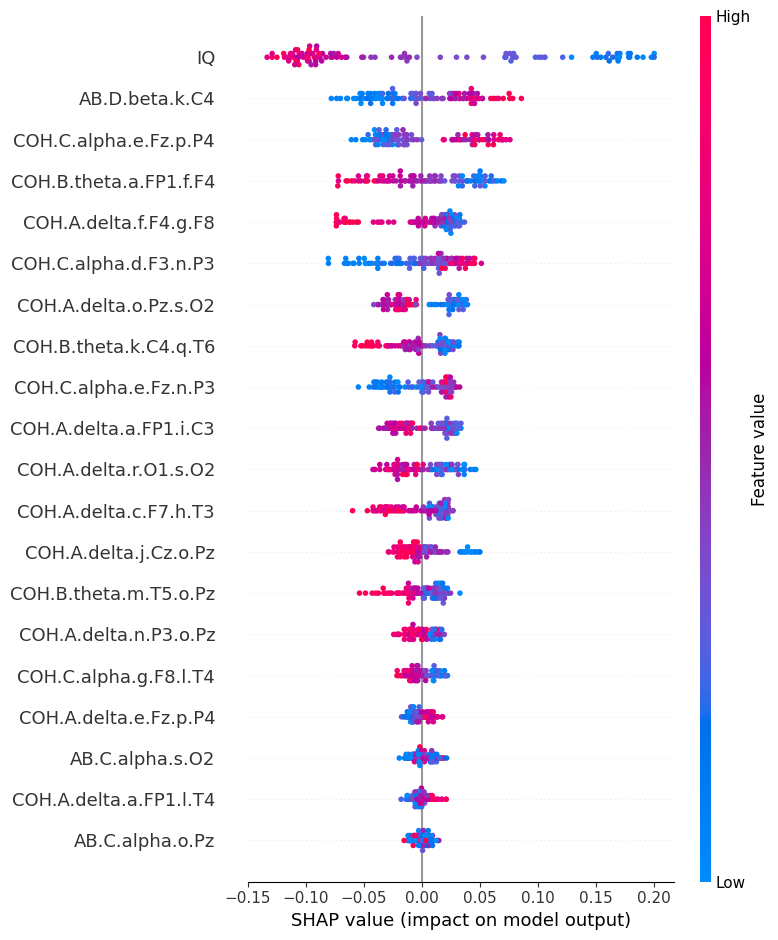

In [39]:
shap.summary_plot(shap_values[:, :, 1], X_selected)

In [ ]:
shap.dependence_plot('IQ', shap_values[:, :, 1], X_selected)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [40]:
import matplotlib.pyplot as plt

plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_selected, show=False)
plt.savefig("results/shap_summary_plot.png", bbox_inches="tight")
plt.close()